In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import warnings
from tqdm import tqdm

In [4]:
from multicam.mah import get_mah

# Collect MAH data

In [5]:
mah_data = get_mah('../../data/processed/bolshoi_m12/', cutoff_missing=0.05, cutoff_particle=0.05)

In [6]:
# catalog
cat = mah_data['cat']
xoff = cat['x0']
cvir = cat['cvir']
ma = mah_data['ma_peak']
am = mah_data['am']

indices = mah_data['indices']
scales = mah_data['scales']
mass_bins = mah_data['mass_bins']
print(cvir.shape, xoff.shape, am.shape, ma.shape, scales.shape, mass_bins.shape)

(10000,) (10000,) (10000, 100) (10000, 165) (165,) (100,)


# Construct indicators and merger ratio at each snapshot

In [7]:
# scale factor coarser bins 
min_scale, max_scale = np.min(scales), np.max(scales)
scale_bins = np.linspace(min_scale, max_scale, 20)
scale_bins

array([0.18635   , 0.22919211, 0.27203421, 0.31487632, 0.35771842,
       0.40056053, 0.44340263, 0.48624474, 0.52908684, 0.57192895,
       0.61477105, 0.65761316, 0.70045526, 0.74329737, 0.78613947,
       0.82898158, 0.87182368, 0.91466579, 0.95750789, 1.00035   ])

In [8]:
# for each simulation scale, get MM 
# first we need merger ratio at every scale 
merger_ratio_inst  = np.zeros((len(cat), len(scales)))
merger_ratio_present = np.zeros((len(cat), len(scales)))
for i in range(len(cat)):
    for j, idx in enumerate(indices): 
        m2_name = f'm2_a{idx}' # TODO: Check what this corresponds to
        cpg_name = f'coprog_mvir_a{idx-1}' # want coprogenitor mass at previous timestep.
        mvir_name = f'mvir_a{idx}'
        
        # get inst ratios
        m2_ratio = cat[m2_name][i].item() / cat[mvir_name][i].item()
        merger_ratio_inst[i, j] = m2_ratio
        
        # present ratios
        m2_ratio = cat[m2_name][i] / cat['mvir'][i].item()
        merger_ratio_present[i, j] = m2_ratio
    

In [9]:
# construct indicator for each halo whether they have a MM in a given scale bine 
Mu = [0.3/1.3, 0.1 / 1.1 , 0.03 / (1 + 0.03), 0.01 / 1.01]
inst_mask = np.zeros((len(Mu), len(cat), len(scale_bins)-1))
present_mask = np.zeros((len(Mu), len(cat), len(scale_bins)-1))

# ignore all nanmax warning, these will return np.nan's which is expected. 
warnings.simplefilter("ignore", category=RuntimeWarning)

for kk, mu in enumerate(Mu):
    for jj in range(len(scale_bins) - 1):
        # get largest merger ratio in this scale bin
        mask = (scales >= scale_bins[jj]) & (scales < scale_bins[jj+1])
        inst_mask[kk, :, jj] = np.nanmax(merger_ratio_inst[:, mask], axis=1) > mu
        present_mask[kk, :, jj] = np.nanmax(merger_ratio_present[:, mask], axis=1) > mu

# Training

In [10]:
from multicam.models import LinearRegression

## Train standard MultiCAM

In [11]:
x = ma

y = np.concatenate([cat['cvir'][:, None], cat['x0'][:, None], cat['t/|u|'][:, None], 
                    cat['spin_bullock'][:, None], cat['c_to_a'][:,None]], 
                    axis=1)

mc = LinearRegression(165, 5)

In [12]:
mc.fit(x,y)

In [13]:
mc.predict(x)[4, 0], mc.predict(x[4, None, :])[0,0] # almost the same

(8.474221229553223, 8.53542423248291)

In [14]:
# get mean cvir and mean predicted cvir for sanity check
cvir_mean = np.mean(cat['cvir'])
cvir_pred_mean = np.mean(mc.predict(x)[:,0])
np.abs(cvir_mean - cvir_pred_mean) / np.abs(cvir_mean) # very low error

5.262648795182711e-05

## Train MultiCAM with diffmah curves

In [15]:
diffmah_curves = np.load("../../data/processed/diffmah_fits.npy")
diffmah_curves.shape

x = diffmah_curves

y = np.concatenate([cat['cvir'][:, None], cat['x0'][:, None], cat['t/|u|'][:, None], 
                    cat['spin_bullock'][:, None], cat['c_to_a'][:,None]], 
                    axis=1)

mc_smooth = LinearRegression(165, 5)

In [16]:
mc_smooth.fit(x, y)

## MultiCAM with merger ratios

In [17]:
x1 = ma

mask2 = np.isnan(merger_ratio_inst)
x2 = np.where(mask2, 0, merger_ratio_inst)

x = np.concatenate([x1, x2], axis=1)

y = np.concatenate([cat['cvir'][:, None], cat['x0'][:, None], cat['t/|u|'][:, None], 
                    cat['spin_bullock'][:, None], cat['c_to_a'][:,None]], 
                    axis=1)

mc_merger = LinearRegression(330, 5)

In [18]:
mc_merger.fit(x, y)

## MultiCAM with (coarse) merger ratios

In [19]:
# use coarser bins for merger bins like in the 'merger residuals' plots

x1 = ma

mask2 = np.isnan(merger_ratio_inst)
x2 = np.where(mask2, 0, merger_ratio_inst)

# use scale_bins instead of scales, take max over mergers in each bin.
x3 = np.zeros((x2.shape[0], scale_bins.shape[0]))
for ii, scale in enumerate(scales):
    jj = np.where(scale >= scale_bins)[0][-1]
    arr = np.vstack([x3[:, jj], x2[:, ii]])
    assert arr.shape == (2, 10000)
    x3[:, jj] = np.max(arr, axis=0)
    

In [20]:
x = np.concatenate([x1, x3], axis=1)

y = np.concatenate([cat['cvir'][:, None], cat['x0'][:, None], cat['t/|u|'][:, None], 
                    cat['spin_bullock'][:, None], cat['c_to_a'][:,None]], 
                    axis=1)

mc_merger2 = LinearRegression(185, 5)

In [21]:
mc_merger2.fit(x, y)

# Results

## Merger factions as a function of scale

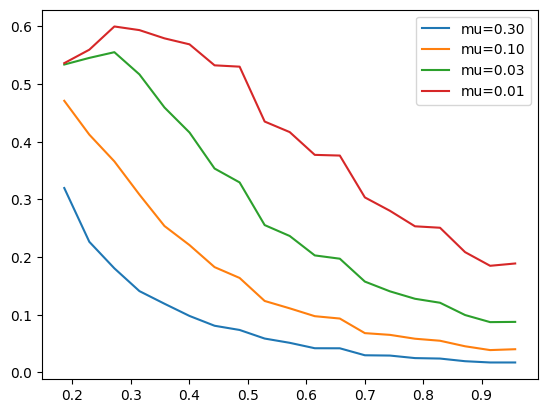

In [22]:
# instantaneous
for kk, mu in enumerate(Mu):
    _mu = mu / (1 - mu)
    plt.plot(scale_bins[:-1], inst_mask[kk, :].sum(axis=0) / 10000, label=f'mu={_mu:.2f}')
plt.legend()

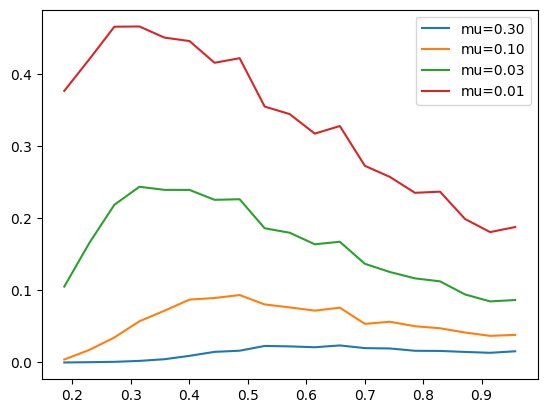

In [23]:
# present day 
for kk, mu in enumerate(Mu):
    _mu = mu / (1 - mu)
    plt.plot(scale_bins[:-1], present_mask[kk, :].sum(axis=0) / 10000, label=f'mu={_mu:.2f}')
plt.legend()

## Correlations

In [24]:
y_pred = mc.predict(ma)
y_pred_smooth = mc_smooth.predict(diffmah_curves)
y_pred_merger = mc_merger.predict(np.concatenate((x1, x2), axis=1))
y_pred_merger2 = mc_merger2.predict(np.concatenate((x1, x3), axis=1))

In [25]:
from multicam.correlations import spearmanr
params = ('cvir', 'x0', 't/|u|', 'spin_bullock', 'c_to_a')

for ii in range(5):
    print(params[ii], ":")
    print('standard:', spearmanr(y_pred[:, ii], y[:,ii]))
    print('smooth:', spearmanr(y_pred_smooth[:, ii], y[:,ii]))
    print('merger all bins:', spearmanr(y_pred_merger[:, ii], y[:,ii]))
    print('merger coarse bins:', spearmanr(y_pred_merger2[:, ii], y[:,ii]))
    print()

cvir :
standard: 0.8063608693988956
smooth: 0.7839841158184729
merger all bins: 0.818994633106362
merger coarse bins: 0.8239810267033048

x0 :
standard: 0.6668671540696616
smooth: 0.6288801227807701
merger all bins: 0.6755357788084462
merger coarse bins: 0.6790754731362528

t/|u| :
standard: 0.7610004451595668
smooth: 0.7095956608167642
merger all bins: 0.7802238217072371
merger coarse bins: 0.7930816178526208

spin_bullock :
standard: 0.5016656806716475
smooth: 0.5044628817584901
merger all bins: 0.5154402456995596
merger coarse bins: 0.5058168018832009

c_to_a :
standard: 0.5289490353167811
smooth: 0.5181691650306504
merger all bins: 0.5440567017114321
merger coarse bins: 0.5332201209590539



The merger one is higher than the ones by the standard MultiCAM method, but are they significant?

## Get scatter residuals

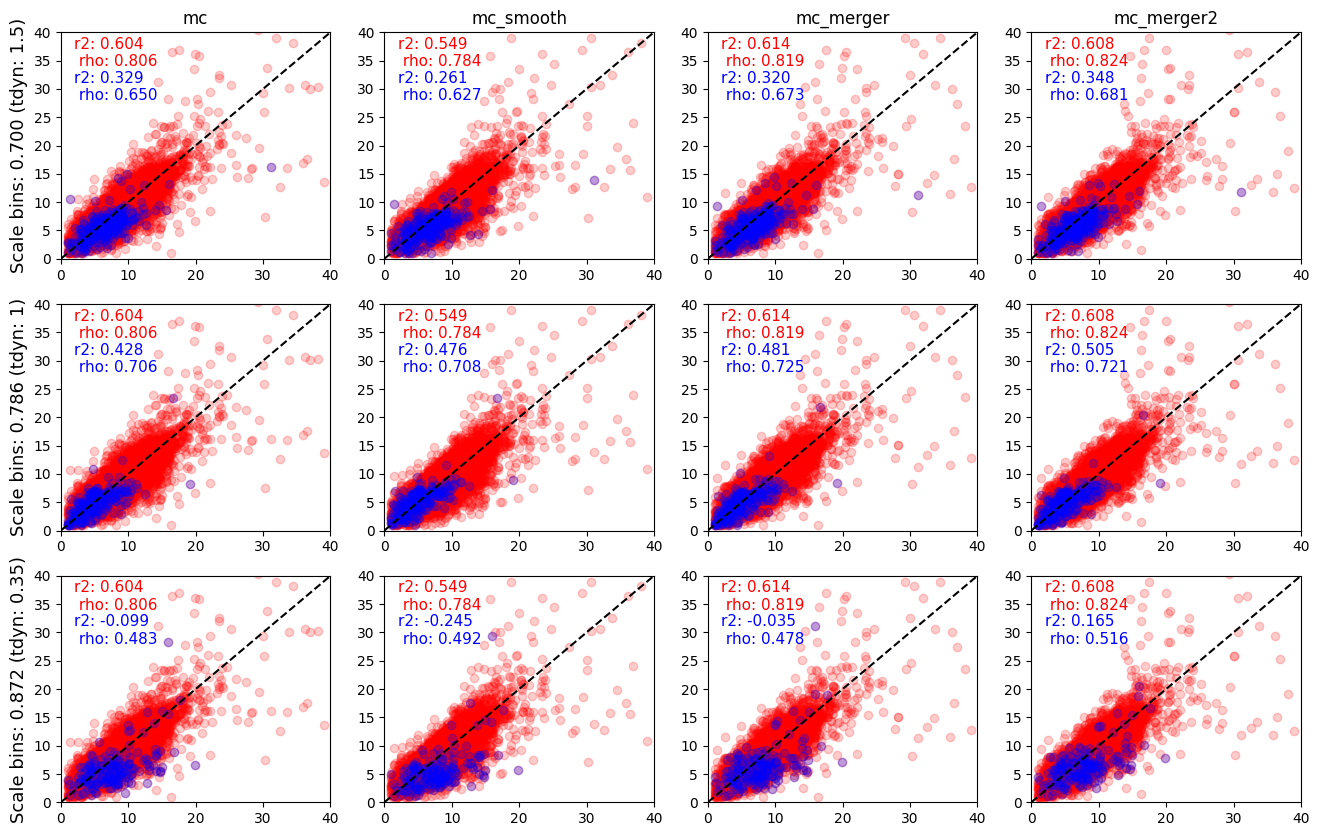

In [26]:
from sklearn.metrics import r2_score

fig, axes = plt.subplots(3, 4, figsize=(16, 10))

models = [mc, mc_smooth, mc_merger, mc_merger2]
model_names = ['mc', 'mc_smooth', 'mc_merger', 'mc_merger2']

x = [ma, diffmah_curves, np.concatenate((x1, x2), axis=1), np.concatenate((x1, x3), axis=1)]

y = np.concatenate([cat['cvir'][:, None], cat['x0'][:, None], cat['t/|u|'][:, None], 
                    cat['spin_bullock'][:, None], cat['c_to_a'][:,None]], 
                    axis=1)

scale_indices = [12, 14, 16]
tdyn = [1.5, 1, 0.35]  # in Gyr

for ii in range(3): 
    mask = inst_mask[0, :, scale_indices[ii]].astype(bool)
    for jj in range(4):
        ax = axes[ii, jj]
        x_jj = x[jj]
        model_jj = models[jj]
        y_pred = model_jj.predict(x_jj)[:, 0] # concentration
        y_true = y[:, 0]

        corr1 = spearmanr(y_true, y_pred)
        r21 = r2_score(y_true, y_pred)

        corr2 = spearmanr(y_true[mask], y_pred[mask])
        r22 = r2_score(y_true[mask], y_pred[mask])

        ax.scatter(y_true, y_pred, alpha=0.2, c='r')
        ax.scatter(y_true[mask], y_pred[mask], alpha=0.25, c='b')
        ax.plot([0, 45], [0, 45], c='k', ls='--')
        ax.set_xlim(0, 40)
        ax.set_ylim(0, 40)

        ax.text(0.05, 0.85, f'r2: {r21:.3f}\n rho: {corr1:.3f}', transform=ax.transAxes, fontsize=11, color='r')
        ax.text(0.05, 0.70, f'r2: {r22:.3f}\n rho: {corr2:.3f}', transform=ax.transAxes, fontsize=11, color='b')


        if ii == 0:
            ax.set_title(model_names[jj])
        if jj == 0:
            ax.set_ylabel(f'Scale bins: {scale_bins[scale_indices[ii]]:.3f} (tdyn: {tdyn[ii]})', fontsize=13)

## Get merger residuals per scale bin and merger ratio

### MultiCAM (standard)

In [27]:
x = ma

y = np.concatenate([cat['cvir'][:, None], cat['x0'][:, None], cat['t/|u|'][:, None], 
                    cat['spin_bullock'][:, None], cat['c_to_a'][:,None]], 
                    axis=1)

params = ('cvir', 'x0', 't/|u|', 'spin_bullock', 'c_to_a')

In [28]:
# now get residual for each scale bin and for each mu, separating haloes using the indicators
residual_merger = np.zeros((len(Mu), len(scale_bins) - 1, len(params)))
residual_no_merger = np.zeros((len(Mu), len(scale_bins) - 1, len(params)))
resid = (mc.predict(x) - y)/y

for kk, mu in enumerate(Mu):
    for jj in range(len(scale_bins) - 1):
        mask = inst_mask[kk, :, jj].astype(bool)
        residuals_merger = resid[mask]
        residuals_no_merger = resid[~mask]
        
        residual_merger[kk, jj, :] = np.median(residuals_merger, axis=0)
        residual_no_merger[kk, jj, :] = np.median(residuals_no_merger, axis=0)

Text(0.5, 0, 'Scale')

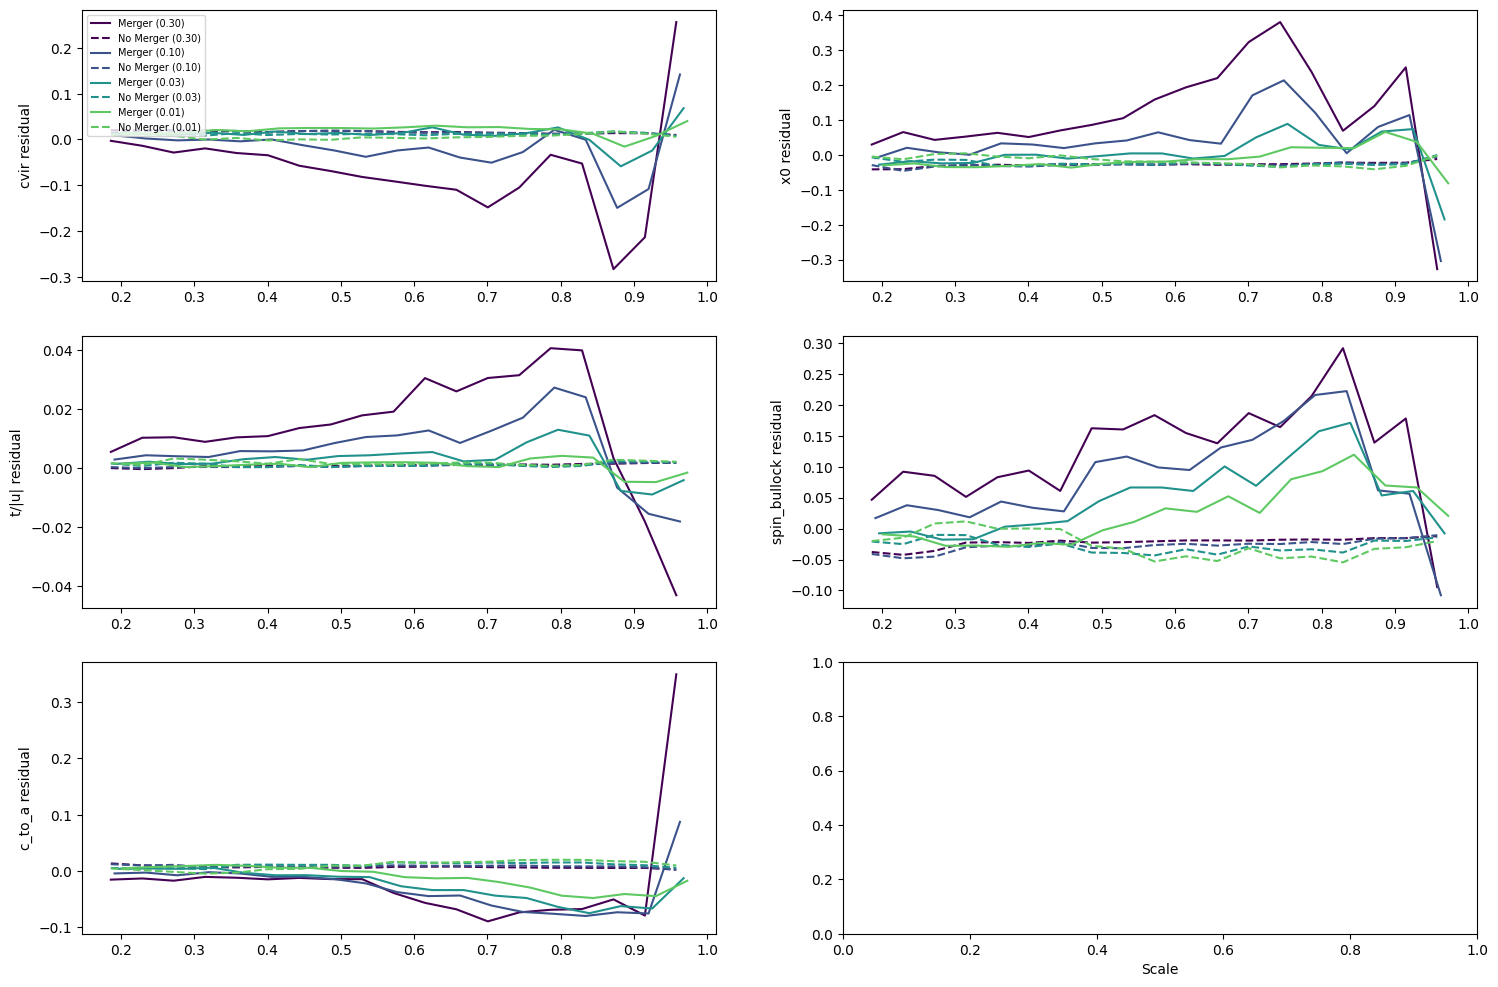

In [29]:
# make plot of median and quartile residuals for each parameter for each merger ratio as a function of scale
# all merger ratios are in the same plot with a color gradient indicating higher merger ratio
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
axes = axes.flatten()
for ii, param in enumerate(params):
    for jj, mu in enumerate(Mu):
        color = plt.cm.viridis(jj / len(Mu))
        lmu = mu / ( 1- mu)
        axes[ii].plot(scale_bins[:-1]+0.005*jj, residual_merger[jj, :, ii], label=f"Merger ({lmu:.2f})", color=color)
        axes[ii].plot(scale_bins[:-1], residual_no_merger[jj, :, ii], label=f"No Merger ({lmu:.2f})", color=color, ls='--')
    axes[ii].set_ylabel(f'{param} residual')
axes[0].legend(loc='upper left', prop={'size': 7})
axes[-1].set_xlabel('Scale')

### MultiCAM (coarse merger bins)

In [30]:
# use coarser bins for merger bins like in the 'merger residuals' plots

x1 = ma

mask2 = np.isnan(merger_ratio_inst)
x2 = np.where(mask2, 0, merger_ratio_inst)

# use scale_bins instead of scales, take max over mergers in each bin.
x3 = np.zeros((x2.shape[0], scale_bins.shape[0]))
for ii, scale in enumerate(scales):
    jj = np.where(scale >= scale_bins)[0][-1]
    arr = np.vstack([x3[:, jj], x2[:, ii]])
    assert arr.shape == (2, 10000)
    x3[:, jj] = np.max(arr, axis=0)

x = np.concatenate([x1, x3], axis=1)

y = np.concatenate([cat['cvir'][:, None], cat['x0'][:, None], cat['t/|u|'][:, None], 
                    cat['spin_bullock'][:, None], cat['c_to_a'][:,None]], 
                    axis=1)

In [31]:
# now get residual for each scale bin and for each mu, separating haloes using the indicators
residual_merger = np.zeros((len(Mu), len(scale_bins) - 1, len(params)))
residual_no_merger = np.zeros((len(Mu), len(scale_bins) - 1, len(params)))
resid = (mc_merger2.predict(x) - y)/y

for kk, mu in enumerate(Mu):
    for jj in range(len(scale_bins) - 1):
        mask = inst_mask[kk, :, jj].astype(bool)
        residuals_merger = resid[mask]
        residuals_no_merger = resid[~mask]
        
        residual_merger[kk, jj, :] = np.median(residuals_merger, axis=0)
        residual_no_merger[kk, jj, :] = np.median(residuals_no_merger, axis=0)

Text(0.5, 0, 'Scale')

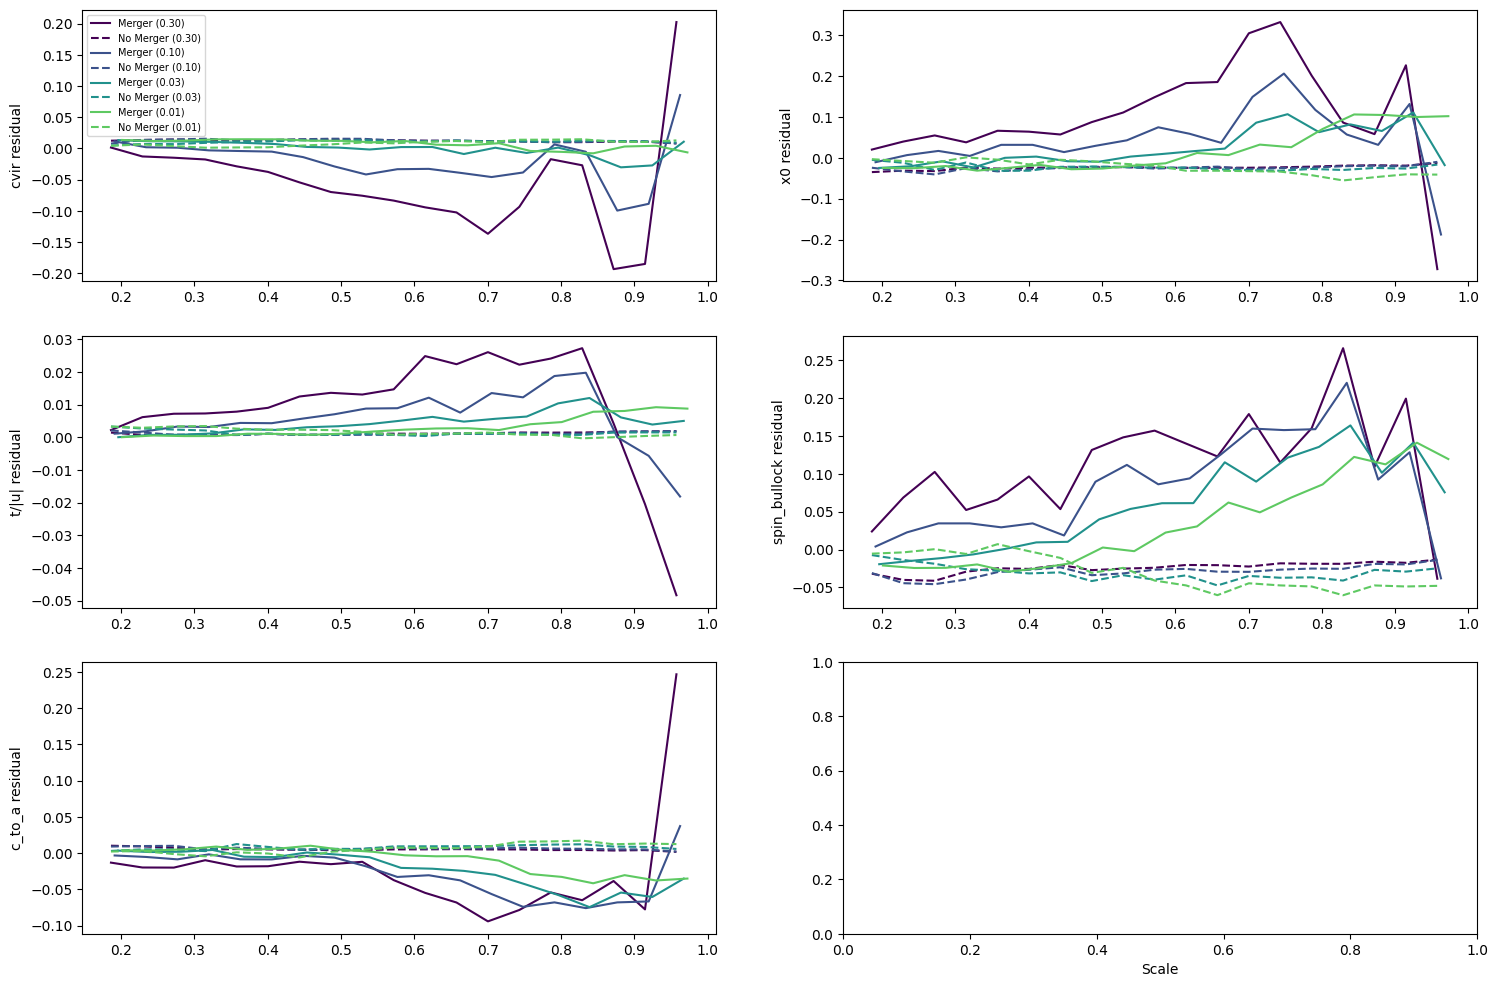

In [32]:
# make plot of median and quartile residuals for each parameter for each merger ratio as a function of scale
# all merger ratios are in the same plot with a color gradient indicating higher merger ratio
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
axes = axes.flatten()
for ii, param in enumerate(params):
    for jj, mu in enumerate(Mu):
        color = plt.cm.viridis(jj / len(Mu))
        lmu = mu / ( 1- mu)
        axes[ii].plot(scale_bins[:-1]+0.005*jj, residual_merger[jj, :, ii], label=f"Merger ({lmu:.2f})", color=color)
        axes[ii].plot(scale_bins[:-1], residual_no_merger[jj, :, ii], label=f"No Merger ({lmu:.2f})", color=color, ls='--')
    axes[ii].set_ylabel(f'{param} residual')
axes[0].legend(loc='upper left', prop={'size': 7})
axes[-1].set_xlabel('Scale')

## Concentration outliers

In [33]:
x = ma

y = np.concatenate([cat['cvir'][:, None], cat['x0'][:, None], cat['t/|u|'][:, None], 
                    cat['spin_bullock'][:, None], cat['c_to_a'][:,None]], 
                    axis=1)

In [34]:
y_pred = mc.predict(x)[:,0]
resid = (y[:,0] - y_pred)/y[:,0]

# get 95% outliers
outliers = np.abs(resid) > np.percentile(np.abs(resid), 95)

In [35]:
outlier_mah = ma[outliers]
outlier_mah.shape

(500, 165)

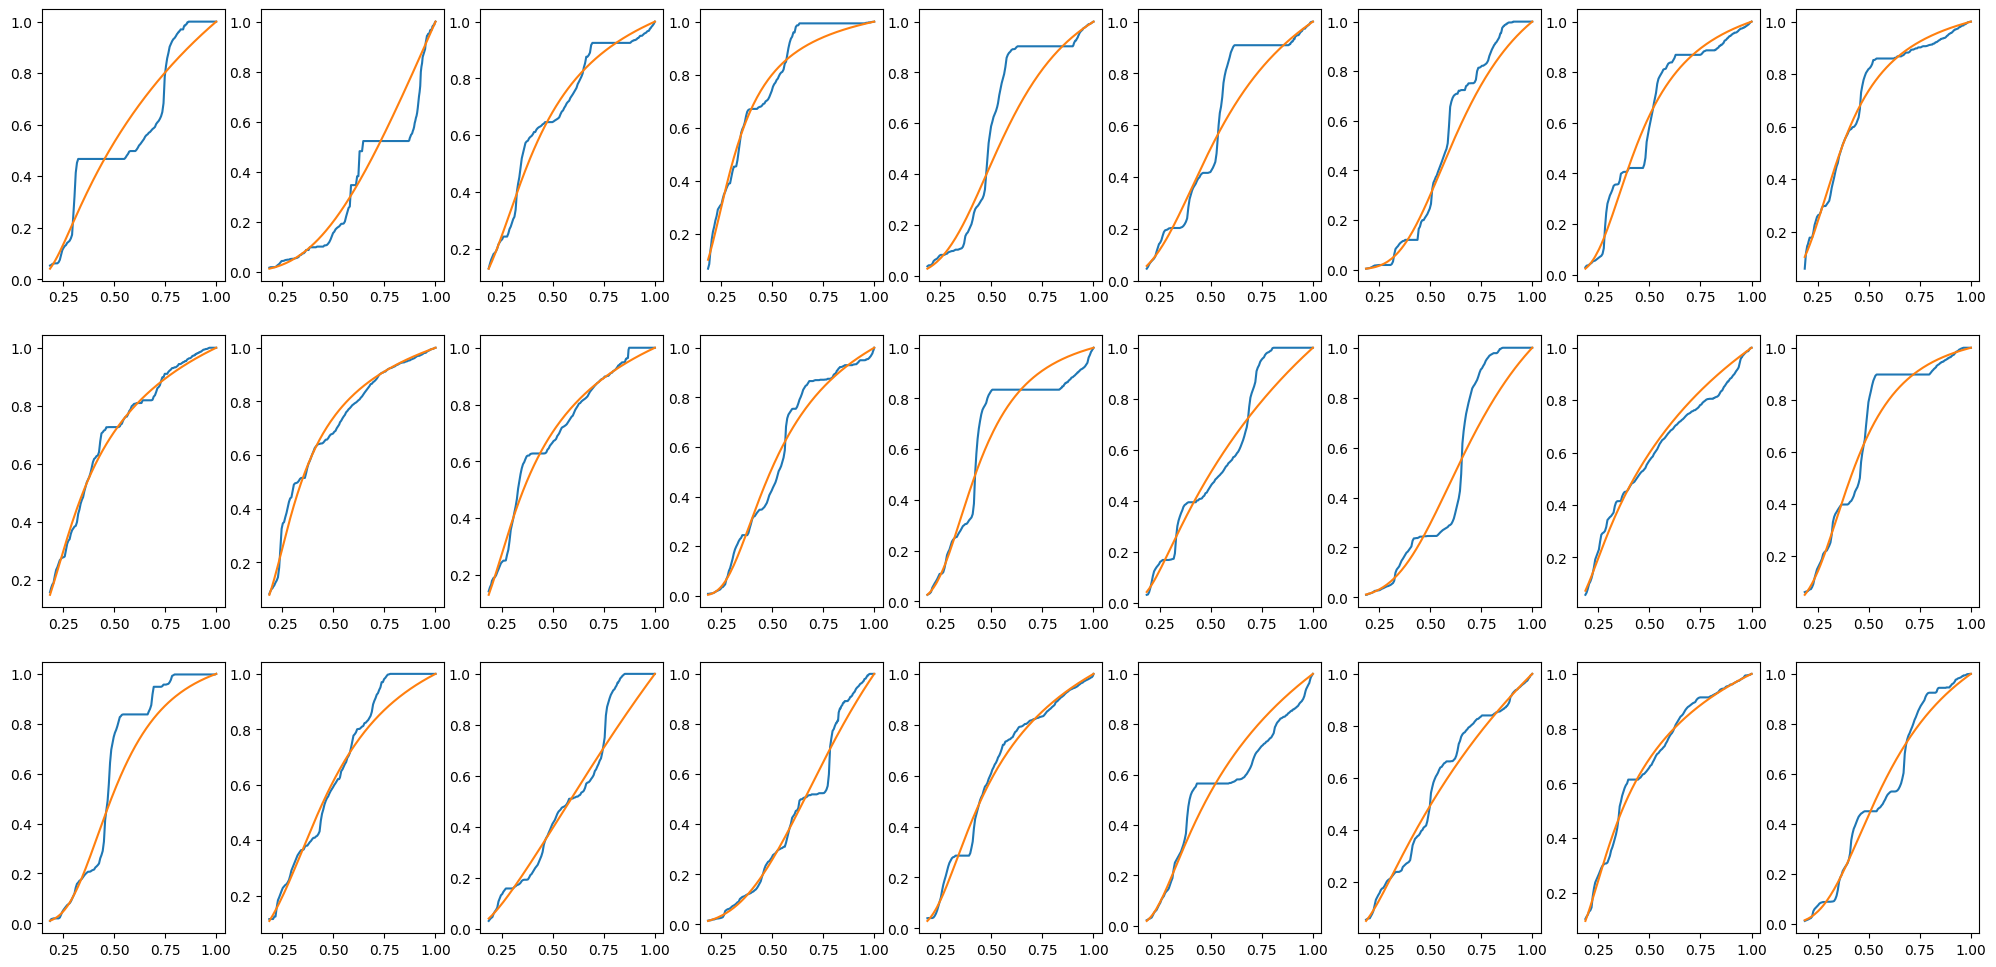

In [36]:
# plot random normal MAH
fig, axes = plt.subplots(3, 9, figsize=(25, 12))
axes = axes.flatten()
ii = np.random.randint(0, 10000, size=27)
for ii in range(27):
    axes[ii].plot(scales, ma[ii], color='C0')
    axes[ii].plot(scales, diffmah_curves[ii], color='C1')

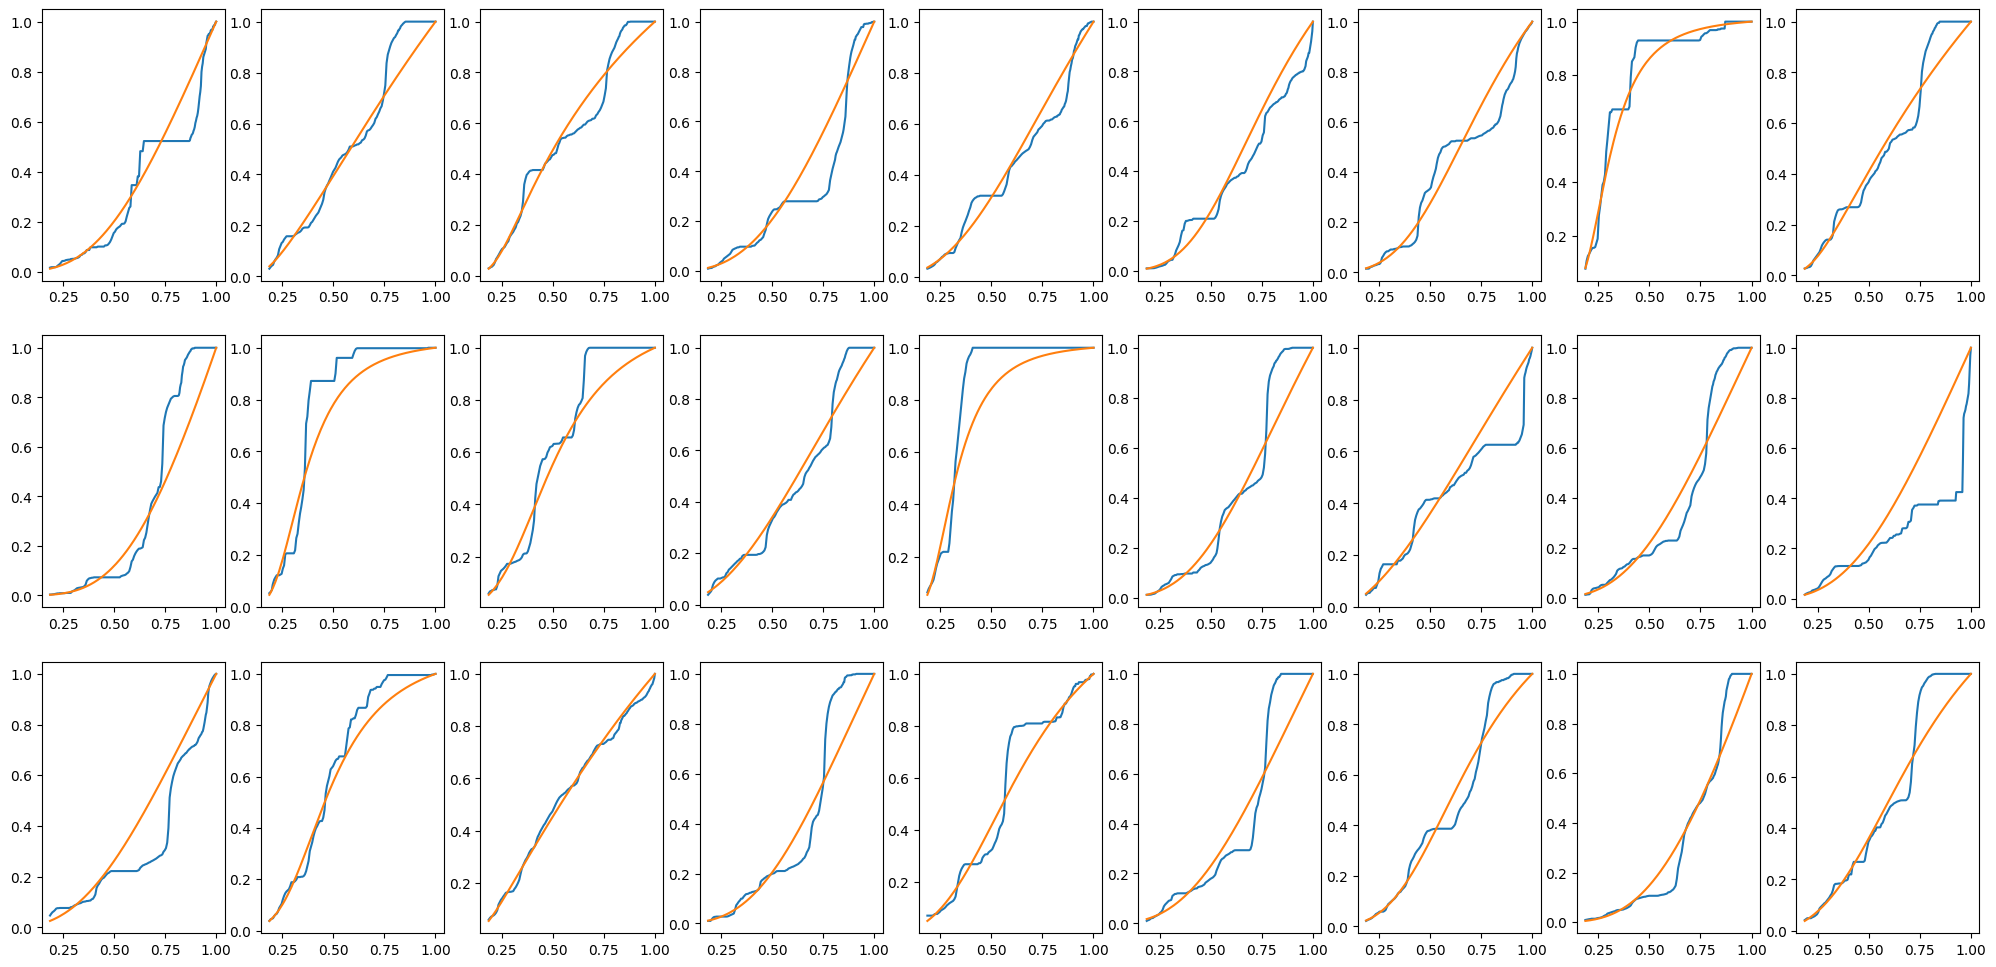

In [37]:
# plot MAH of outliers
fig, axes = plt.subplots(3, 9, figsize=(25, 12))
for ii, ax in enumerate(axes.flatten()):
    ax.plot(scales, outlier_mah[ii])
    ax.plot(scales, diffmah_curves[outliers][ii])